# Ultimate Data Challenge

Exploration and Time Series Analysis of User Logins Time Stamps from a particular location. The dataset being used in the logins.json dataset from Ultimate Inc.

In [48]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA

In [2]:
df = pd.read_json('logins.json').reset_index()

In [3]:
print('max: ' + str(min(df['login_time'])))
print('min: ' + str(max(df['login_time'])))

max: 1970-01-01 20:12:16
min: 1970-04-13 18:57:38


- The first recorded time stamp was on January 1st 1970
- The last recorded time stamp was on April 13th of the same year


I am interested of counting the number of logins over different time intervals. For this purpose I am engineering an additional column  df['login'] to keep track of these counts. I also need to set an index equal to constant time intervals over the time interval of interest.

In [4]:
df['login'] = 1


rng = pd.date_range(start=min(df['login_time']), end=max(df['login_time']), freq='D')
df = df.set_index('login_time')
dff = pd.merge(df, pd.Series(index=rng, name='rng'), how='outer', left_index=True, right_index=True).drop('rng', 1).fillna(0)

In [11]:
dff_aggregated = dff.resample('15min').agg('login').sum().reset_index()

Aggregating should reduce the size of the dataset, and it does.

In [12]:
dff.shape
dff_aggregated.shape

(9788, 2)

## Plot of 15 minute interval logins


Plotting the 15 minute intervals directly doesn't show us much.

In [14]:
dff_aggregated.head()

,index,login
0,1970-01-01 20:00:00,2.0
1,1970-01-01 20:15:00,6.0
2,1970-01-01 20:30:00,9.0
3,1970-01-01 20:45:00,7.0
4,1970-01-01 21:00:00,1.0


In [15]:
dff_aggregated.head()

,index,login
0,1970-01-01 20:00:00,2.0
1,1970-01-01 20:15:00,6.0
2,1970-01-01 20:30:00,9.0
3,1970-01-01 20:45:00,7.0
4,1970-01-01 21:00:00,1.0


Text(0.5, 1.0, 'Daily Logins')

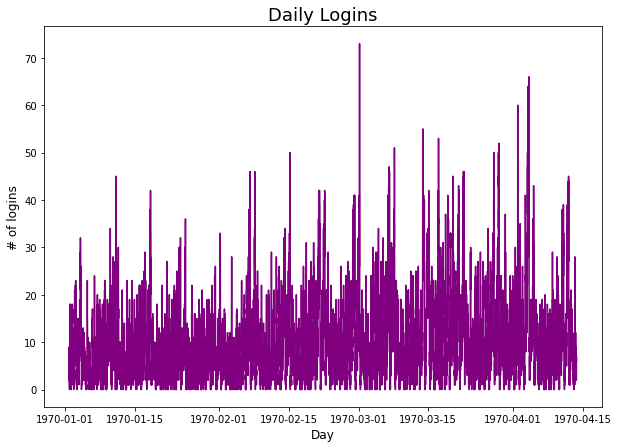

In [16]:
fig_dims = (10, 7)
fig, ax = plt.subplots(figsize=fig_dims)

sns.lineplot(x = 'index', 
             y = 'login',
             data = dff_aggregated,
             color = 'purple')


plt.xlabel("Day", size=12)
plt.ylabel("# of logins", size=12)
plt.title("Daily Logins", size=18)


- We could go on to further explore morning, afternoon, night volumes
- Distribution by hour of the day


In [18]:
dff_aggregated['hour_of_day'] = dff_aggregated['index'].dt.hour

Text(0.5, 1.0, 'Hourly Logins')

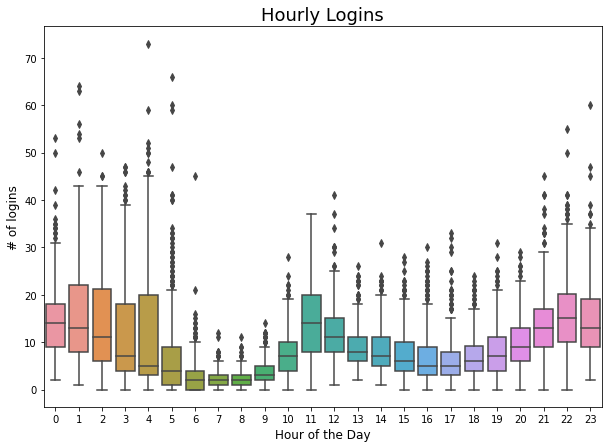

In [19]:
fig_dims = (10, 7)
fig, ax = plt.subplots(figsize=fig_dims)

sns.boxplot(x = 'hour_of_day',
            y = 'login', 
            data = dff_aggregated)

plt.xlabel("Hour of the Day", size=12)
plt.ylabel("# of logins", size=12)
plt.title("Hourly Logins", size=18)

## Plot of Daily login volumes

In [20]:
dff_days = dff.resample('D').agg('login').sum().reset_index()

Text(0.5, 1.0, 'Daily Logins')

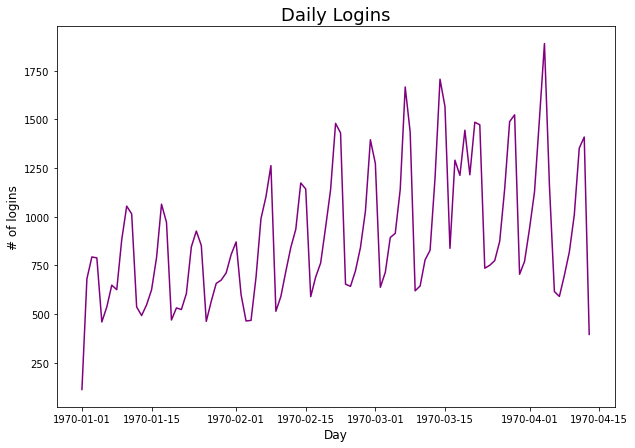

In [21]:
fig_dims = (10, 7)
fig, ax = plt.subplots(figsize=fig_dims)

sns.lineplot(x = 'index', 
              y = 'login',
             data = dff_days,
             color = 'purple')


plt.xlabel("Day", size=12)
plt.ylabel("# of logins", size=12)
plt.title("Daily Logins", size=18)

The most obvious oscillation seen is that on a weekly basis. First, I am going to investigate what the oscillating interval is and whether that is indeed a week. 

We can see that there is a slight upward trend as time goes on. This suggests there is a trend, in this case an increase in the mean # of daily logins . The oscillations also appear to be getting larger, suggesting a possibility of a non-constant variance as well. This will be looked into further when modelling.

In [22]:
dff_days['day_of_the_week'] = dff_days['index'].dt.date

dff_days['day_of_the_week'] = pd.to_datetime(dff_days['day_of_the_week'], format = '%Y-%m-%d')
dff_days['day_of_the_week'] = dff_days['day_of_the_week'].dt.day_name()

Text(0.5, 1.0, 'Daily Logins')

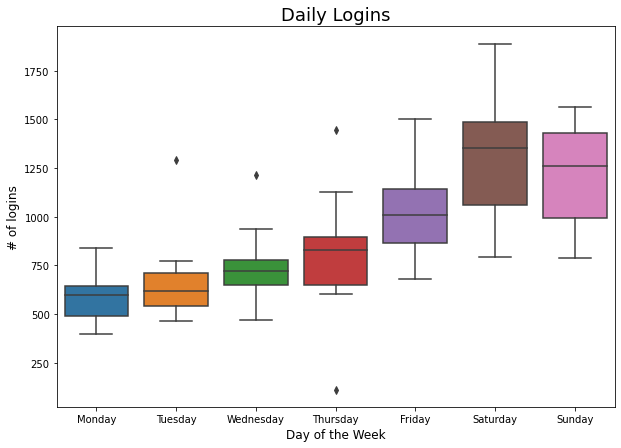

In [23]:
fig_dims = (10, 7)
fig, ax = plt.subplots(figsize=fig_dims)

sns.boxplot(x = 'day_of_the_week',
            y = 'login',
            data = dff_days,
            ax = ax,
            order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])


plt.xlabel("Day of the Week", size=12)
plt.ylabel("# of logins", size=12)
plt.title("Daily Logins", size=18)

## Weekly Logins

In [24]:
dff_weeks = dff.resample('W').agg('login').sum().reset_index()
dff_weeks.head()

,index,login
0,1970-01-04,2374.0
1,1970-01-11,5217.0
2,1970-01-18,5023.0
3,1970-01-25,4751.0
4,1970-02-01,4744.0


Text(0.5, 1.0, 'Weekly Logins')

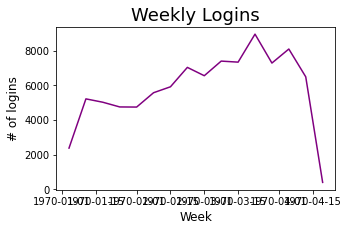

In [25]:
fig_dims = (5, 3)
fig, ax = plt.subplots(figsize=fig_dims)

sns.lineplot(x = 'index', 
             y = 'login',
             data = dff_weeks,
             color = 'purple')


plt.xlabel("Week", size=12)
plt.ylabel("# of logins", size=12)
plt.title("Weekly Logins", size=18)

There's a big dropoff in the last weeks because the week is not complete. Would need to slice the dataset early if I were interested in forecasting over a weekly time period.

The same is true for a monthly interval. It would not be appropriate to include April. 

In [26]:
dff_months = dff.resample('M').agg('login').sum().reset_index()

Text(0.5, 1.0, 'Monthly Logins')

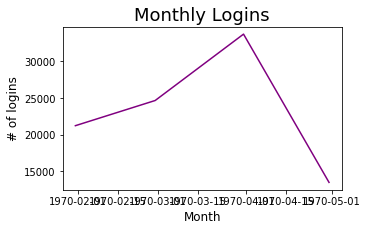

In [27]:
fig_dims = (5, 3)
fig, ax = plt.subplots(figsize=fig_dims)

sns.lineplot(x = 'index', 
             y = 'login',
             data = dff_months,
             color = 'purple')


plt.xlabel("Month", size=12)
plt.ylabel("# of logins", size=12)
plt.title("Monthly Logins", size=18)

# Forecasting activity for the upcoming week

Since I only have one column of data that includes timestamps, and I am seeing significant oscillations in the data, I am inclined to use an ARIMA model. 


The parameters of an ARIMA model are: 



- p: lag order, which is the number of lag observations included in the model
- d: degree of differencing, so the number of times raw observations are differenced
- q: moving average, which is the size of the moving average window


First I will need to split the data into a train and test set

In [34]:
dff_days = dff_days.set_index('index')

KeyError: "None of ['index'] are in the columns"

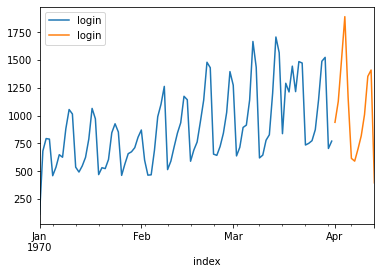

In [29]:
train = dff_days.loc[:'1970-03-31']
test = dff_days.loc['1970-04-01':]
fig, ax = plt.subplots()

train.plot(ax=ax)
test.plot(ax=ax)
plt.show()

To check whether the time series, when taken at daily intervals, is stationary, I am going to use the <b>Augmented Dickey-Fuller</b> test.

In [30]:
result = adfuller(dff_days['login'])


print('test statistic: ' + str(result[0]))
print('p-value: ' + str(result[1]))
print('critical value: ' + str(result[2]))

test statistic: -1.4033164919219874
p-value: 0.5806851218557996
critical value: 13


The p-value is > 0.05 so I cannot reject the hypothesis that the timeseries is non-stationary. Differencing will be necessary to make the time series stationary.

In [38]:
dff_days = dff_days.drop('day_of_the_week', axis =1)

In [40]:
days_stationary = dff_days.diff().dropna()

In [42]:
result = adfuller(days_stationary['login'])

print('test statistic: ' + str(result[0]))
print('p-value: ' + str(result[1]))
print('critical value: ' + str(result[2]))

test statistic: -4.224797553035273
p-value: 0.0005980298052095068
critical value: 13


The p-value after differencing is now < 0.05 which means that we can reject the null hypothesis that the series is non-stationary.

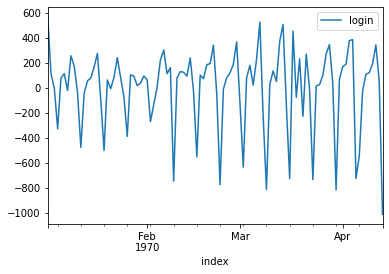

In [43]:
fig, ax = plt.subplots()
days_stationary.plot(ax=ax)
plt.show()


The time series now looks relatively stationary to me. If differencing didn't work, we would have to use other transformations to make the time series stationary. 

In [45]:
days_stationary.head()

,login
index,
1970-01-02,569.0
1970-01-03,112.0
1970-01-04,-5.0
1970-01-05,-329.0
1970-01-06,77.0


In [49]:
y = days_stationary['login']

model = ARMA(y, order=(1,1))

In [50]:
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  login   No. Observations:                  102
Model:                     ARMA(1, 1)   Log Likelihood                -719.903
Method:                       css-mle   S.D. of innovations            276.215
Date:                Wed, 07 Apr 2021   AIC                           1447.806
Time:                        20:35:38   BIC                           1458.305
Sample:                    01-02-1970   HQIC                          1452.057
                         - 04-13-1970                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           5.2815      1.686      3.132      0.002       1.976       8.587
ar.L1.login     0.4707      0.094      5.002      0.000       0.286       0.655
ma.L1.login    -0.9999      0.030    -33.609      0.000      -1.058      -0.942
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.1244           +0.0000j            2.1244            0.0000
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""